# Understanding and Predicting Employee Turnover
## HR Analytics
***
<img src = "../images/turnover_2.png"/>

## Table Of Contents
***
### The Problem
- [The business problem](#problem)

### Objective
- [Goal of the notebook](#objective)

### Data Quality Check
- [Simple Inspection of Data](#dataQualityCheck)

### Descriptive Statistics
- [Univariate Analysis](#univariate)
- [Bivariate Values](#bivariate)
- [K-means clustering for Employee Turnover](#kmeans)
- [Correlation Matrix](#correlation)

### Data Preprocessing
- [Encoding](#encoding)
- [Train Test Split](#trainTestSplit)

### Class Imbalance
- [Class Imbalance](#classImbalance)
- [How to treat Imbalance Dataset](#imbalanceDataset)

### Modelling
- [Logistic Regression](#logisticRegression)
- [SVC](#svc)
- [Decision Tree Classifier](#decisionTree)
- [Random Forest Classifier](#randomForest)
- [Gradient Boosting Classifier](#gradientBoost)
- [ROC Curve](#roc)
- [Save Models to disk](#saveModels)

### Feature Importance

### Conclusion
***

<img src="../images/turnover_gif.gif"/>

<a id = 'problem'></a>
# Business Problem
***
A high employee turnover rate, the rate at which employees leave a business, can affect the bottom line of businesses of all sizes. Here are two very crucial business problems due to high turnover rate:
1. **Cost Implications**
Replacing workers can be expensive. While the cost varies, some studies have shown the cost to replace and hire new staff as high as 60 percent of the old employee’s salary. In addition, total costs of replacement, including training and lost production, can range from 90 percent to 200 percent of an employee’s annual salary.
2. **Overall Business Performance**
In addition, oftentimes the employees who remain with a company are less productive and less efficient than they would have been in a lower turnover environment. This is because they must absorb the responsibilities of the vacant positions, train new employees upon their arrival, and deal with a depressed work culture and environment. As a result, companies with lower retention rates and high turnover are often less competitive and produce less than companies with a stable workforce.

<a id = 'objective'></a>
# Objective
***
- To understand what factors contributed most to employee turnover.

- To perform clustering to find any meaningful patterns of employee traits.

- To create a model that predicts the likelihood if a certain employee will leave the company or not. 

- To create or improve different retention strategies on targeted employees. 

# Import Packages
***

In [1]:
# Import the neccessary modules for data manipulation and visual representation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC 

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Read the data
***

In [2]:
df = pd.read_csv('../input/HR_comma_sep.csv.xls')

<a id = 'dataQualityCheck'></a>
# Data Quality Check
***

In [3]:
# Examine the train dataset
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
# Check the type of our features. Are there any data inconsistencies?
df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

In [5]:
# Can you check to see if there are any missing values in our data set
df.isnull().any()

satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
left                     False
promotion_last_5years    False
sales                    False
salary                   False
dtype: bool

In [6]:
# Rename columns
df = df.rename(columns={'satisfaction_level': 'satisfaction', 
                        'last_evaluation': 'evaluation',
                        'number_project': 'projectCount',
                        'average_montly_hours': 'averageMonthlyHours',
                        'time_spend_company': 'yearsAtCompany',
                        'Work_accident': 'workAccident',
                        'promotion_last_5years': 'promotion',
                        'sales' : 'department',
                        'left' : 'turnover'
                        })

In [7]:
df.shape

(14999, 10)

# Exploratory Data Analysis
***

In [8]:
# Display the statistical overview of the attributes
df.describe()

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,turnover,promotion
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [9]:
df.astype('object').describe()

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,turnover,promotion,department,salary
count,14999.0,14999.00,14999,14999,14999,14999,14999,14999,14999,14999
unique,92.0,65.00,6,215,8,2,2,2,10,3
top,0.1,0.55,4,135,3,0,0,0,sales,low
freq,358.0,358.00,4365,153,6443,12830,11428,14680,4140,7316


<a id = 'univariate'></a>
## Univariate Analysis
***

### Turnover Distribution
***

In [10]:
turnover_percent = df.turnover.value_counts(1)
turnover_percent

0    0.761917
1    0.238083
Name: turnover, dtype: float64

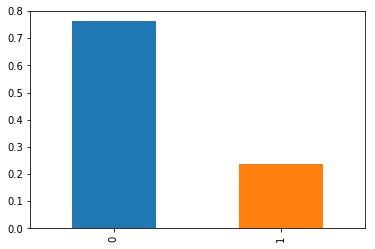

In [11]:
turnover_percent.plot.bar()

**Observation:**
1. There is huge class imbalance. We have 76% of employees who stayed, while only 23% employees who left.

In [12]:
# Display the mean summary of Employees (Turnover V.S. Non-turnover). What do you notice between the groups?
turnover_Summary = df.groupby('turnover')
turnover_Summary.mean()

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion
turnover,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


In [13]:
turnover_Summary.std()

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,promotion
turnover,,,,,,,
0,0.217104,0.162005,0.979884,45.682731,1.562348,0.379991,0.159889
1,0.263933,0.197673,1.818165,61.202825,0.977698,0.212364,0.072759


**Observations:**
1. Employees with higher satisfaction has lower turnover rate.
2. Evaluation does not seem to have impact on turnover rate.
3. Higher average monthly hours can be seen among employees who left.
4. Work accident don't seem to have impact on turnover left.
5. The promotion rate is way too less among people who left.

### Numerical Attributes
***

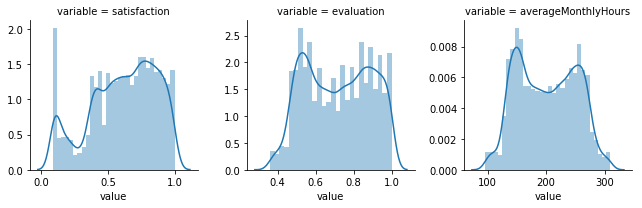

In [14]:
quantitative = ['satisfaction', 'evaluation', 'averageMonthlyHours']
f = pd.melt(df, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

Text(0,0.5,'Hours')

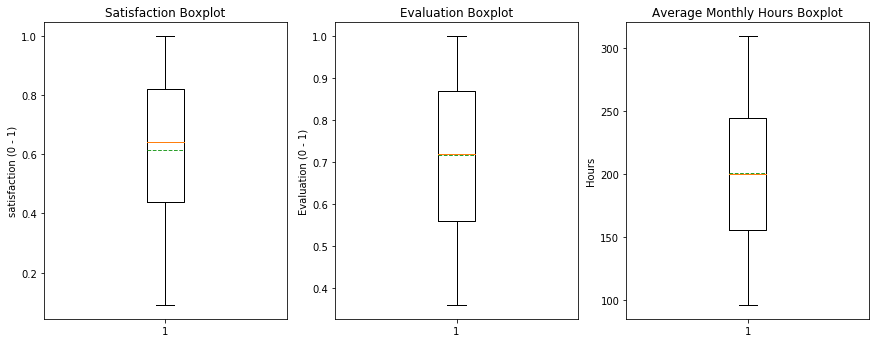

In [15]:
plt.figure(figsize=[20,12])

plt.subplot(241)
plt.boxplot(x=df['satisfaction'], showmeans = True, meanline = True)
plt.title('Satisfaction Boxplot')
plt.ylabel('satisfaction (0 - 1)')

plt.subplot(242)
plt.boxplot(df['evaluation'], showmeans = True, meanline = True)
plt.title('Evaluation Boxplot')
plt.ylabel('Evaluation (0 - 1)')

plt.subplot(243)
plt.boxplot(df['averageMonthlyHours'], showmeans = True, meanline = True)
plt.title('Average Monthly Hours Boxplot')
plt.ylabel('Hours')

**Observations:**
1. The distribution of satisfaction, evaluation and averageMonthlyHours are multimodal.

### Catgorical Attributes
***

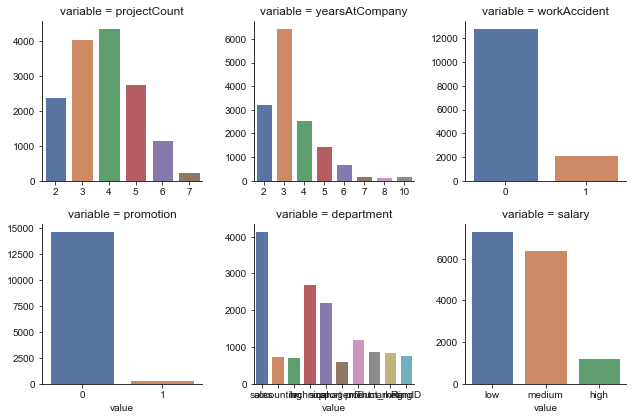

In [16]:
def countplot(x,**kwargs):
    sns.set(style="darkgrid")
    ax = sns.countplot(x=x, data=f)
    
qualitative = ['projectCount','yearsAtCompany', 'workAccident', 
               'promotion', 'department','salary']
f = pd.melt(df, value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False)
g = g.map(countplot, "value")

### Department distribution
***

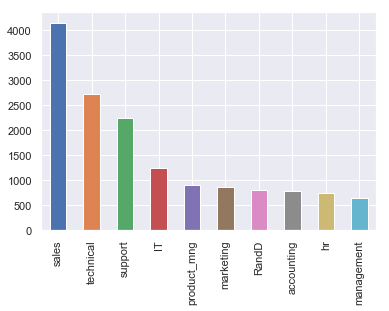

In [17]:
df['department'].value_counts().plot.bar()

<a id = 'bivariate'></a>
## Bivariate Analysis
***

### Numerical Attributes
***

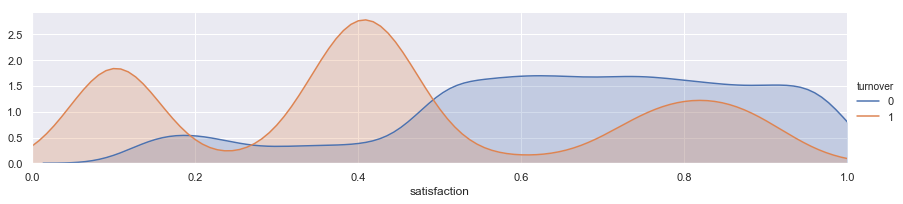

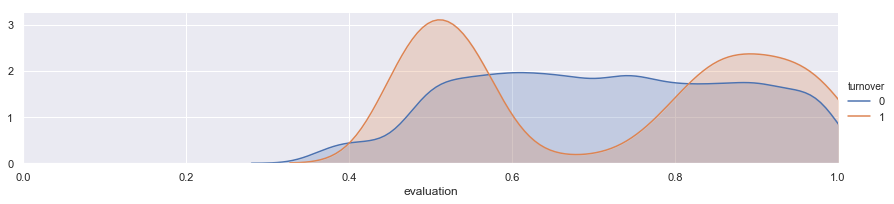

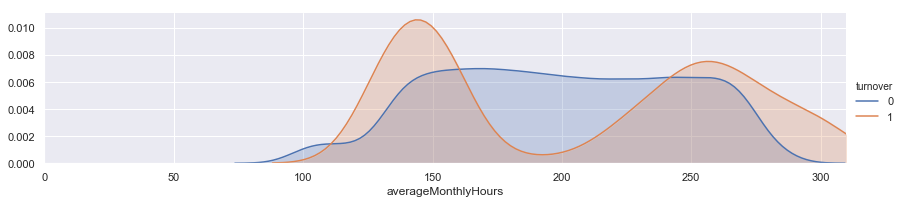

In [18]:
for col in quantitative:   
    a = sns.FacetGrid( df, hue = 'turnover', aspect=4 )
    a.map(sns.kdeplot, col, shade= True )
    a.set(xlim=(0 , df[col].max()))
    a.add_legend()

**Observations:**
1. Employees with higher satisfaction has lower turnover rate.
2. Employees evaluation doesn't have much say in turnover rate.
3. Turnover rates are higher among employees who has either low average monthly hours or too high average monthly hours.

### Categorical Attributes
***

In [19]:
#Discrete Variable Correlation by Turnover using group by
for x in qualitative:
    print(' Correlation by:', x)
    print(df[[x, 'turnover']].groupby(x, as_index=False).mean())
    print('-'*10, '\n')

 Correlation by: projectCount
   projectCount  turnover
0             2  0.656198
1             3  0.017756
2             4  0.093700
3             5  0.221659
4             6  0.557922
5             7  1.000000
---------- 

 Correlation by: yearsAtCompany
   yearsAtCompany  turnover
0               2  0.016338
1               3  0.246159
2               4  0.348064
3               5  0.565513
4               6  0.291086
5               7  0.000000
6               8  0.000000
7              10  0.000000
---------- 

 Correlation by: workAccident
   workAccident  turnover
0             0  0.265160
1             1  0.077916
---------- 

 Correlation by: promotion
   promotion  turnover
0          0  0.241962
1          1  0.059561
---------- 

 Correlation by: department
    department  turnover
0           IT  0.222494
1        RandD  0.153748
2   accounting  0.265971
3           hr  0.290934
4   management  0.144444
5    marketing  0.236597
6  product_mng  0.219512
7        sales  0.24

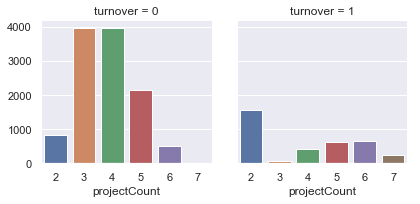

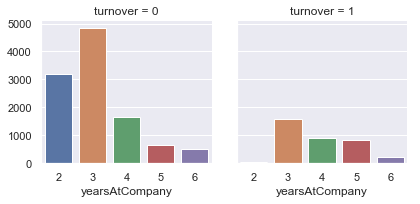

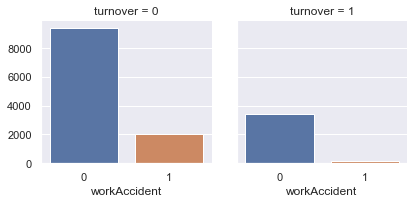

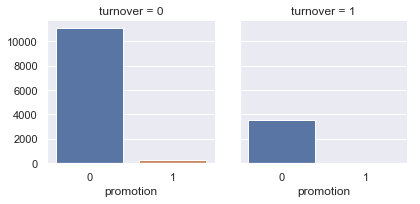

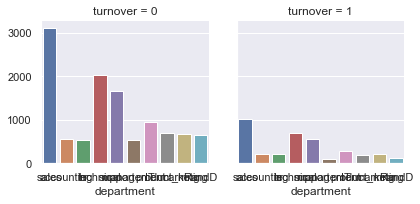

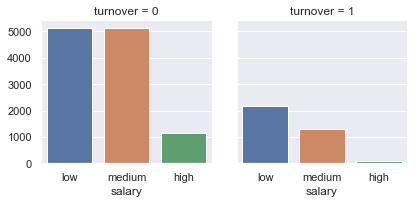

In [20]:
def countplot(x,**kwargs):
    sns.set(style="darkgrid")
    ax = sns.countplot(x=x, data=df)
    
for col in qualitative:
    g = sns.FacetGrid(df, col="turnover", col_wrap = 2)
    g.map(countplot, col)

**Observations:**
1. Employees with lowest project count i.e., 2 have higher turnover rate.
2. Surprisingly, "Work accident" doesn't say much about turnover.
3. Among the employees who left, none had promotion.
4. Employees with lower salary are more likely to leave.

### Department versus Turnover
***

In [21]:
hrleft = df[df['turnover']==1]

hrleft = pd.DataFrame(hrleft.department.value_counts()).reset_index()
hrstay = pd.DataFrame(df.department.value_counts()).reset_index()

hr_merge = pd.merge(hrleft, hrstay, how='inner', on='index')

hr_merge = hr_merge.rename(columns={"department_x":'left', "department_y":'stayed', "index":'department' })
hr_merge

,department,left,stayed
0,sales,1014,4140
1,technical,697,2720
2,support,555,2229
3,IT,273,1227
4,hr,215,739
5,accounting,204,767
6,marketing,203,858
7,product_mng,198,902
8,RandD,121,787
9,management,91,630


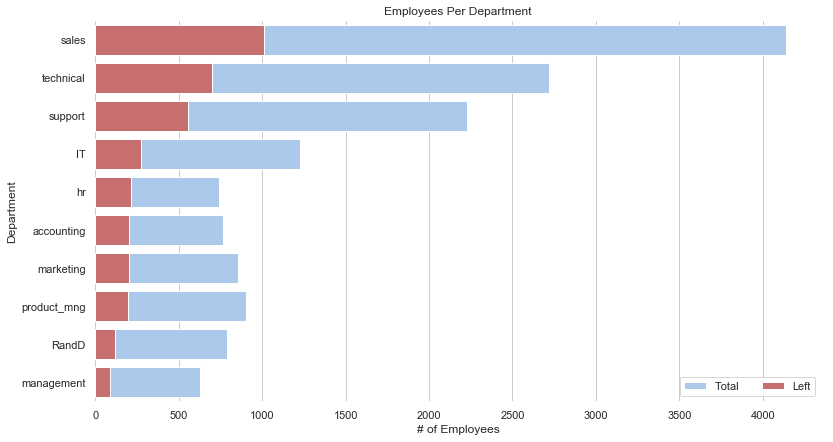

In [22]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

sns.set_color_codes("pastel")
sns.barplot(x="stayed", y='department', data=hr_merge,
            label="Total", color="b")

sns.set_color_codes("muted")
sns.barplot(x="left", y="department", data=hr_merge,
            label="Left", color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Department", title='Employees Per Department',
       xlabel="# of Employees")
sns.despine(left=True, bottom=True)

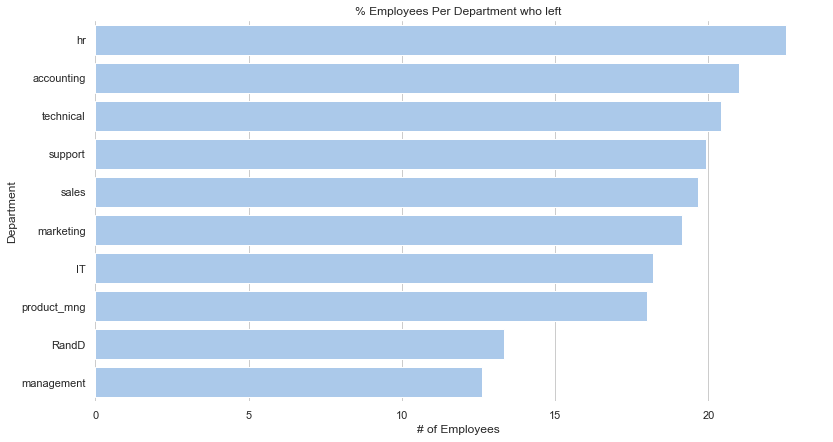

In [23]:
hr_merge['left_percent'] = (hr_merge['left']*100)/(hr_merge['left'] + hr_merge['stayed'])
hr_merge = hr_merge.sort_values(by = 'left_percent', ascending = False)

sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

sns.set_color_codes("pastel")
sns.barplot(x="left_percent", y='department', data=hr_merge,
            label="percent label", color="b")

# Add a legend and informative axis label
ax.set( ylabel="Department", title='% Employees Per Department who left',
       xlabel="# of Employees")
sns.despine(left=True, bottom=True)

**Observations:**
1. HR, accounting and technical department are three departments with highest turnover rate, which is more than 20%.

<a id = 'multivariate'></a>
## Multivariate Analysis
***

### Satisfaction - Evaluation versus Turnover
***

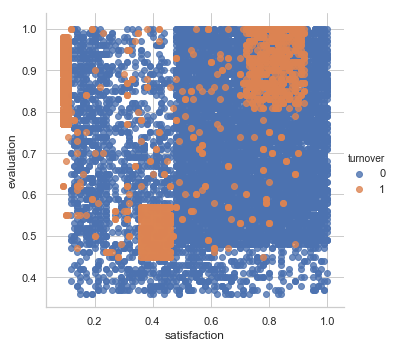

In [24]:
sns.lmplot(x='satisfaction', y='evaluation', data=df,
           fit_reg=False, # No regression line
           hue='turnover')   # Color by evolution stage

**Observations:**
There are three kinds of employee who left the company:
1. Employees with higher evaluation but lower satisfaction.
2. Employees with lower evaluation but a bit satisfied with the company.
3. Employees with higher evaluation and higher satisfaction.

<a id = 'kmeans'></a>
##  K-Means Clustering of Employee Turnover
***

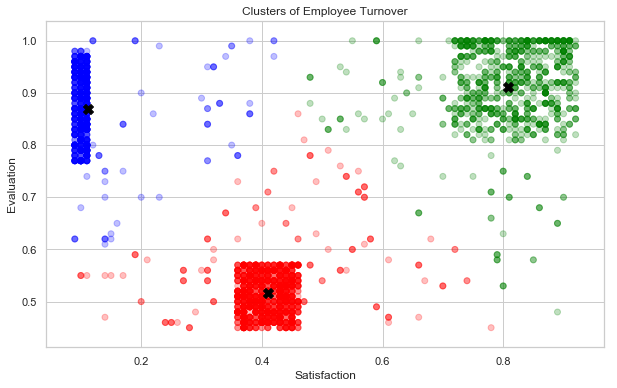

In [25]:
# Import KMeans Model
from sklearn.cluster import KMeans

# Graph and create 3 clusters of Employee Turnover
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(df[df.turnover==1][["satisfaction","evaluation"]])

kmeans_colors = ['green' if c == 0 else 'blue' if c == 2 else 'red' for c in kmeans.labels_]

fig = plt.figure(figsize=(10, 6))
plt.scatter(x="satisfaction",y="evaluation", data=df[df.turnover==1],
            alpha=0.25,color = kmeans_colors)
plt.xlabel("Satisfaction")
plt.ylabel("Evaluation")
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black",marker="X",s=100)
plt.title("Clusters of Employee Turnover")
plt.show()

There are three clusters, which define three kinds of employees:

**Cluster 1 (Blue):** Hard-working and Sad Employees

**Cluster 2 (Red):** Bad and Sad Employee 

**Cluster 3 (Green):** Hard-working and Happy Employee 

<a id = 'correlation'></a>
## Correlation Matrix
***

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,turnover,promotion
satisfaction,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,-0.388375,0.025605
evaluation,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,0.006567,-0.008684
projectCount,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,0.023787,-0.006064
averageMonthlyHours,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,0.071287,-0.003544
yearsAtCompany,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.144822,0.067433
workAccident,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,-0.154622,0.039245
turnover,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,1.000000,-0.061788
promotion,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,-0.061788,1.000000


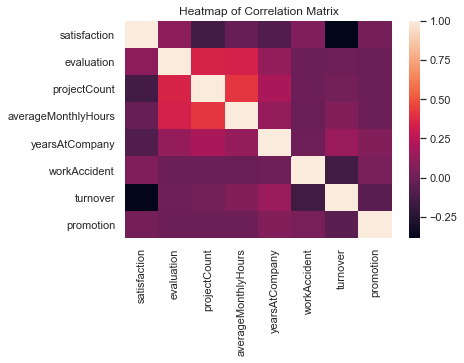

In [26]:
# Create a correlation matrix. What features correlate the most with turnover? What other correlations did you find?
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

# Data Preprocessing
***

<a id = 'encoding'></a>
## Label Encoding
***

In [27]:
columns_to_encode = ['workAccident', 'department', 'salary']

df_encoded_categorical = pd.get_dummies(df[columns_to_encode], drop_first=True)

In [28]:
# create new dataframe using encoded columns and remaining columns
remaining_columns = ['satisfaction', 'evaluation', 'projectCount', 'averageMonthlyHours',
                     'yearsAtCompany', 'promotion']

X = pd.concat([df_encoded_categorical, df[remaining_columns]], axis = 1)
y = df['turnover']

<a id = 'trainTestSplit'></a>
# Train Test Split
***

In [29]:
# Define train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123, stratify=y)

<a id = 'classImbalance'></a>
# Class Imbalance
***
Class Imbalanced is a classification problem where there is a wide gap between the classes. For example, there is a huge class imbalance in employee turnover. We only have **23% of employees who left**, while we have **76% of employees who stayed**.

## What is the harm in Class Imbalance?
We suffer **accuracy paradox** when building predictive models using imbalance dataset. What is accuracy paradox? You are working on your dataset. You create a classification model and get 90% accuracy immediately. “Fantastic” you think. You dive a little deeper and discover that 90% of the data belongs to one class. The reason we get 90% accuracy on an imbalanced data (with 90% of the instances in Class-1) is because our models look at the data and cleverly decide that the best thing to do is to always predict “Class-1” and achieve high accuracy.

<a href = "https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/">(source)</a>

Text(0,0.5,'Count')

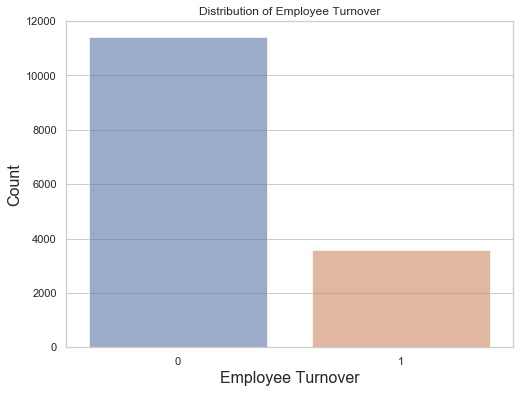

In [30]:
plt.figure(figsize=(8,6))
turnover = df.turnover.value_counts()
sns.barplot(y=turnover.values, x=turnover.index, alpha=0.6)
plt.title('Distribution of Employee Turnover')
plt.xlabel('Employee Turnover', fontsize=16)
plt.ylabel('Count', fontsize=16)

<a id = 'imbalanceDataset'></a>
## How to treat Imbalance Dataset?
***
There are several ways to treat imbalance dataset. However, we will be using the technique of **resampling the dataset**. Following are two ways to resample the dataset:

1. Oversampling — SMOTE
2. Undersampling — RandomUnderSampler

<img src = "../images/sampling_techniques.png"/>

## Approach
***
We will train a base Logistic Regression model for all the three cases:
1. **The Original dataset** 
2. **Under-sampled dataset**
3. **Over-sampled dataset**


This will help us understand if under-sampled and over-sampled dataset indeed brings any improvement to the Machine Learning models.

- Baseline Model: Logistic Regression with 5-folds Cross Validation
- For **undersampling**, we will remove some samples of majority class using **sklearn's resample** package
- For **oversampling**, we will do it using **sklearn's resample package** and **SMOTE**

In [31]:
# Upsample minority class
X_train_u, y_train_u = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=X_train[y_train == 0].shape[0],
                                random_state=1)

X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))


# Upsample using SMOTE
sm = SMOTE(random_state=12, ratio = 1)
x_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)


# Downsample majority class
X_train_d, y_train_d = resample(X_train[y_train == 0],
                                y_train[y_train == 0],
                                replace=True,
                                n_samples=X_train[y_train == 1].shape[0],
                                random_state=1)
X_train_d = np.concatenate((X_train[y_train == 1], X_train_d))
y_train_d = np.concatenate((y_train[y_train == 1], y_train_d))


print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled (using sklearn's resample) shape:", X_train_u.shape, y_train_u.shape)
print ("SMOTE sample shape:", x_train_sm.shape, y_train_sm.shape)
print("Downsampled (using sklearn's resample) shape:", X_train_d.shape, y_train_d.shape)

Original shape: (11999, 18) (11999,)
Upsampled (using sklearn's resample) shape: (18284, 18) (18284,)
SMOTE sample shape: (18284, 18) (18284,)
Downsampled (using sklearn's resample) shape: (5714, 18) (5714,)


In [32]:
# Create the Original, Upsampled, and Downsampled training sets
methods_data = {"Original": (X_train, y_train),
                "Upsampled (using sklearn's resample)": (X_train_u, y_train_u),
                "SMOTE":(x_train_sm, y_train_sm),
                "Downsampled (using sklearn's resample)": (X_train_d, y_train_d)}

# Loop through each type of training sets and apply 5-Fold CV using Logistic Regression
for method in methods_data.keys():
    lr_results = cross_val_score(LogisticRegression(), methods_data[method][0], methods_data[method][1], cv=5, scoring='f1')
    print(f"The best F1 Score for {method} data:")
    print (lr_results.mean())
 
cross_val_score(LogisticRegression(class_weight='balanced'), X_train, y_train, cv=5, scoring='f1').mean()

The best F1 Score for Original data:
0.4496346788932494
The best F1 Score for Upsampled (using sklearn's resample) data:
0.7793364543526724
The best F1 Score for SMOTE data:
0.7880562801129458
The best F1 Score for Downsampled (using sklearn's resample) data:
0.7785231984040071


0.6091127190611549

# Modelling
***

<a id = 'logisticRegression'></a>
## Logistic Regression
***

In [33]:
lr = LogisticRegression()

lr = lr.fit(x_train_sm, y_train_sm)
lr_auc = roc_auc_score(y_test, lr.predict(X_test))

print ("Logistic Regression AUC = %2.2f" % lr_auc)

print(classification_report(y_test, lr.predict(X_test)))

Logistic Regression AUC = 0.78
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      2286
           1       0.51      0.81      0.62       714

   micro avg       0.77      0.77      0.77      3000
   macro avg       0.72      0.78      0.73      3000
weighted avg       0.83      0.77      0.78      3000



<a id = 'svc'></a>
## SVC
***

In [34]:
# Support Vector Classifier Cross Validation
svc = SVC(kernel='rbf', probability=True)  
svc_result = cross_val_score(svc, x_train_sm, y_train_sm, cv=5, scoring='f1')

svc_result.mean()

0.9506357170054198

In [35]:
svc = svc.fit(x_train_sm, y_train_sm)

svc_roc_auc = roc_auc_score(y_test, svc.predict(X_test))
print ("SVC AUC = %2.2f" % svc_roc_auc)
print(classification_report(y_test, svc.predict(X_test)))

SVC AUC = 0.94
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2286
           1       0.83      0.94      0.88       714

   micro avg       0.94      0.94      0.94      3000
   macro avg       0.91      0.94      0.92      3000
weighted avg       0.94      0.94      0.94      3000



<a id = 'decisionTree'></a>
## Decision Tree
***

In [36]:
# Decision tree cross validation
dt = DecisionTreeClassifier()
dt_result = cross_val_score(dt, x_train_sm, y_train_sm, cv=5, scoring='f1')

dt_result.mean()

0.9811241692866457

In [37]:
dt = dt.fit(x_train_sm, y_train_sm)

dt_roc_auc = roc_auc_score(y_test, dt.predict(X_test))
print ("Decision Tree AUC = %2.2f" % dt_roc_auc)
print(classification_report(y_test, dt.predict(X_test)))

Decision Tree AUC = 0.98
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2286
           1       0.94      0.98      0.96       714

   micro avg       0.98      0.98      0.98      3000
   macro avg       0.97      0.98      0.97      3000
weighted avg       0.98      0.98      0.98      3000



<a id = 'randomForest'></a>
## Random Forest
***

In [38]:
# Random Forest Cross Validation
rf = RandomForestClassifier(n_estimators=50)
rf_result = cross_val_score(rf, x_train_sm, y_train_sm, cv=5, scoring='f1')

rf_result.mean()

0.989716390265509

In [39]:
rf = rf.fit(x_train_sm, y_train_sm)

rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
print ("Random Forest AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, rf.predict(X_test)))

Random Forest AUC = 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       0.99      0.98      0.98       714

   micro avg       0.99      0.99      0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



<a id = 'gradientBoost'></a>
## Gradient Boost Classifier
***

In [40]:
gbc = GradientBoostingClassifier()  
gbc = gbc.fit(x_train_sm,y_train_sm)

gbc_auc = roc_auc_score(y_test, gbc.predict(X_test))
print ("Gradient Boosting Classifier AUC = %2.2f" % gbc_auc)
print(classification_report(y_test, gbc.predict(X_test)))

Gradient Boosting Classifier AUC = 0.96
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2286
           1       0.93      0.93      0.93       714

   micro avg       0.97      0.97      0.97      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.97      0.97      0.97      3000



In [41]:
# Gradient Boost Classifier cross validation
gbc_result = cross_val_score(gbc, x_train_sm, y_train_sm, cv=5, scoring='f1')
gbc_result.mean()

0.9695902047111046

<a id = 'roc'></a>
## ROC Curve
***
The Receiver Operating Characteristics (ROC) curve is a common tool used in **binary classifiers**. The ROC Curve plots the true positive rate (i.e., Recall) against the false positive rate.

<img src = "../images/roc.png"/>

The dotted line represents the ROC curve of a purely random classifier, while a good classifier stays as far away from that line as possible (towards the top left corner).

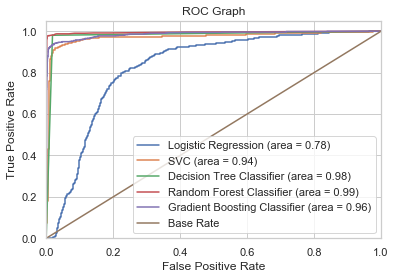

In [42]:
# Create ROC Graph
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
svc_fpr, svc_tpr, svc_thresholds = roc_curve(y_test, svc.predict_proba(X_test)[:,1])
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, dt.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
gbc_fpr, gbc_tpr, gbc_thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:,1])


plt.figure()

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % lr_auc)

# Plot SVC ROC
plt.plot(svc_fpr, svc_tpr, label='SVC (area = %0.2f)' % svc_roc_auc)

# Plot Decision Tree ROC
plt.plot(dt_fpr, dt_tpr, label='Decision Tree Classifier (area = %0.2f)' % dt_roc_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier (area = %0.2f)' % rf_roc_auc)

# Plot Gradiest Boosting Classifier ROC
plt.plot(gbc_fpr, gbc_tpr, label='Gradient Boosting Classifier (area = %0.2f)' % gbc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

<a id = 'saveModels'></a>
## Save Models to disk
***

In [43]:
import pickle

modelList = [(lr, 'LogisticRegression.sav'),
            (svc, 'SVC.sav'),
            (dt, 'DecisionTree.sav'),
            (rf, 'RandomForest.sav'),
            (gbc, 'GradientBoost.sav'),]

for model, filename in modelList:
    pickle.dump(model, open("../models/"+filename, 'wb'))

# Feature importance
***

In [44]:
# Get Feature Importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances = feature_importances.reset_index()
feature_importances

,index,importance
0,satisfaction,0.251231
1,yearsAtCompany,0.246844
2,projectCount,0.176532
3,averageMonthlyHours,0.138016
4,evaluation,0.115943
5,workAccident,0.019474
6,salary_low,0.013752
7,salary_medium,0.007631
8,department_technical,0.007081
9,department_sales,0.005036


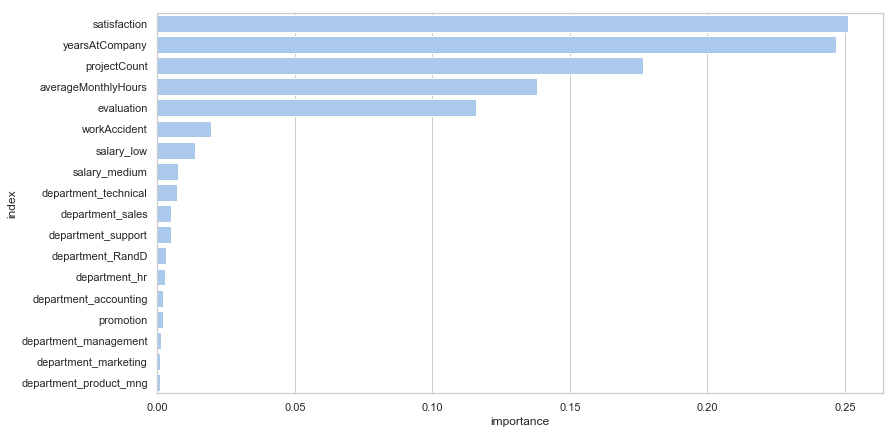

In [45]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the Feature Importance
sns.set_color_codes("pastel")
sns.barplot(x="importance", y='index', data=feature_importances,
            label="Total", color="b")

# Conclusion
***
- The predictive model should be used to fetch the probability of employee leaving the company, instead of the outcome. That way the HR team would know which employees to inspect and work on first.
- Based on our analysis, it is clear that employee satisfaction is the foremost reason that affects turnover. The HR/Turnover Domain, should hear to the reasons of employees with low satisfaction, and work on them.
- We also found out that people with as low project count as 2 were more likely to leave the company. Team has to work out a way to include employees on more projects.
- There are few employees with way too high working hours. They are more likely to be unsatisfied and will eventually leave the company. Measures has to be taken to faciitate the work life balance, and also to recognize their contributions.
- The company should make sure it promotes more number of employees every year because only 300 out of the 15000 were promoted in the last 5 years, which averages to 60 per year, which is too less. If employees are not promoted, they lack the motivation to continue.